In [0]:
import xgboost as xgb

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from hyperopt import hp, tpe, Trials, space_eval
from hyperopt.fmin import fmin
from hyperopt.plotting import main_plot_history

In [0]:
import hyperopt
hyperopt.__version__

'0.2'

## Generate regression dataset

In [0]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=7, n_targets=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

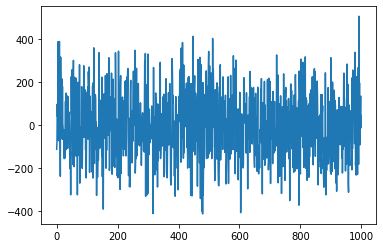

In [0]:
plt.plot(y)

## Loss functions to optimize

In [0]:
def mse_loss_func(estimator, X, y):
    y_pred = estimator.predict(X)
    y_true = y
    return mean_squared_error(y_pred, y_true)

def mape_loss_func(estimator, X, y):
    y_pred = estimator.predict(X)
    y_true = y
    perc_error = (y_pred - y_true) / y_true
    mape = np.mean(np.abs(perc_error)) * 100
    return round(mape, 3)

### Default estimators

XGBoost: 1987.2468983864305
Ridge: 0.07313530364868713
Lasso: 8.278424371678216


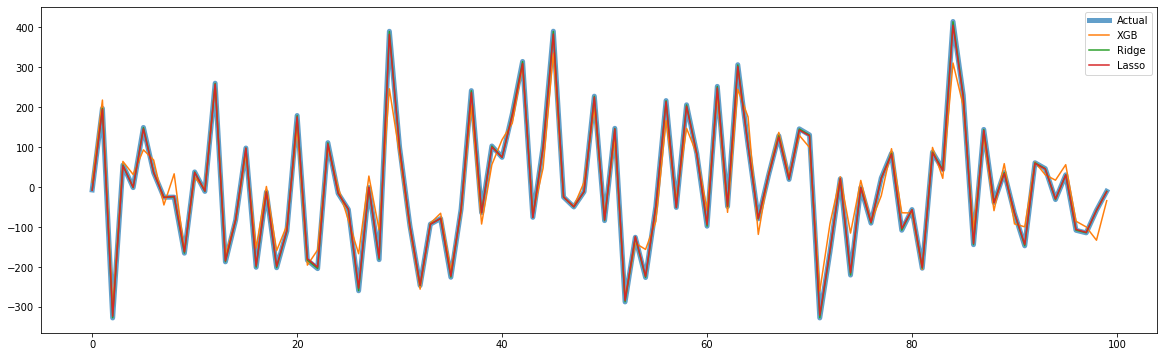

In [0]:
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')
xgb_regressor.fit(X_train, y_train)
xgb_preds = xgb_regressor.predict(X_test)

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)

print(f'XGBoost: {mse_loss_func(estimator=xgb_regressor, X=X_test, y=y_test)}')
print(f'Ridge: {mse_loss_func(estimator=ridge, X=X_test, y=y_test)}')
print(f'Lasso: {mse_loss_func(estimator=lasso, X=X_test, y=y_test)}')

plt.figure(figsize=(20,6))
plt.plot(y_test[-100:], linewidth=5, alpha=0.7)
plt.plot(xgb_preds[-100:])
plt.plot(ridge_preds[-100:])
plt.plot(lasso_preds[-100:])

plt.legend(['Actual', 'XGB', 'Ridge', 'Lasso'])
plt.show()

## Grid Search for XGBoost

In [0]:
%%time 
model = xgb.XGBRegressor(objective='reg:squarederror', gamma=0, random_state=100)

parameters = {'max_depth': [2, 4, 6],
                      'n_estimators': [100, 200, 300],
                      'learning_rate': [0.01, 0.05, 0.1],
                      'reg_alpha': [0.1, 0.7, 1.0],
                      'reg_lambda': [0.1,  0.7, 1.0]
                      }

cv = TimeSeriesSplit(n_splits=5).split(X_train)
grid_search = GridSearchCV(model, param_grid=parameters, cv=cv, scoring=mape_loss_func, verbose=1)
grid_search.fit(X_train, y_train)
      
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
164.2998
CPU times: user 1min 58s, sys: 1.94 s, total: 2min
Wall time: 2min


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:  2.0min finished


In [0]:
estimator = grid_search.best_estimator_
preds = estimator.predict(X_test)
score = mean_squared_error(preds, y_test)
print(score)

3043.136168107734


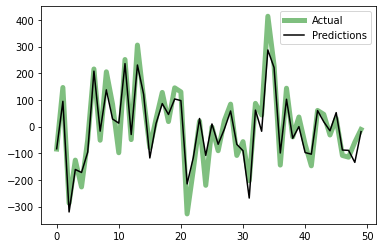

In [0]:
plt.plot(y_test[-50:], linewidth=5, alpha=0.5, c='green')
plt.plot(preds[-50:], c='black')
plt.legend(['Actual', 'Predictions'])

## Hyperopt for XGBoost

In [0]:
%%time
def objective(space):
    clf = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = space['max_depth'],
                           learning_rate = space['learning_rate'],
                           reg_alpha = space['reg_alpha'],
                           reg_lambda = space['reg_lambda'],
                           objective='reg:squarederror', 
                           gamma=0, random_state=100, verbosity=1
                           )
    cv = TimeSeriesSplit(n_splits=5).split(X_train)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=mape_loss_func)
    score = np.mean(scores) 
    return score

space = {'max_depth': hp.choice('max_depth', np.arange(2, 10, 1,  dtype=int)),
         'n_estimators': hp.choice('n_estimators', np.arange(100, 800, 100,  dtype=int)),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1)),
         'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
         'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
        }

trials = Trials()
fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100, 
            trials=trials)

100%|██████████| 100/100 [01:28<00:00,  1.13it/s, best loss: 57.918000000000006]
CPU times: user 1min 26s, sys: 1.57 s, total: 1min 28s
Wall time: 1min 28s


avg best error: 57.918000000000006


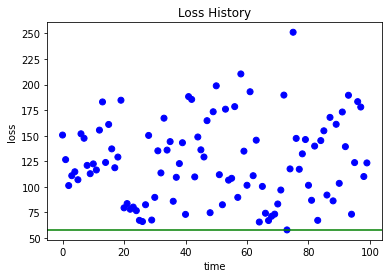

In [0]:
main_plot_history(trials)

In [0]:
params = space_eval(space, trials.argmin)
params

{'learning_rate': 0.2927884513348111,
 'max_depth': 2,
 'n_estimators': 600,
 'reg_alpha': 0.24586777002873267,
 'reg_lambda': 0.7196669245964878}

In [0]:
estimator = xgb.XGBRegressor(objective='reg:squarederror', 
                           gamma=0, random_state=100, verbosity=1, 
                           **params               
                           )
estimator.fit(X_train, y_train)
preds = estimator.predict(X_test)
score = mean_squared_error(preds, y_test)
print(score)

811.9732095193496


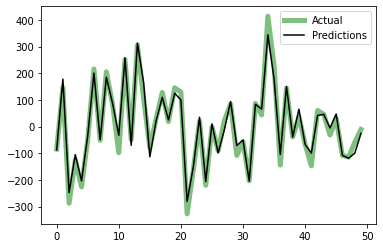

In [0]:
plt.plot(y_test[-50:], linewidth=5, alpha=0.5, c='green')
plt.plot(preds[-50:], c='black')
plt.legend(['Actual', 'Predictions'])

## Selecting among different angorithms

In [0]:
space_linear = hp.choice('regressor_type', [
                                            # ridge configuration
                                            {'type': 'ridge', 
                                             'ridge_alpha': hp.uniform('ridge_alpha', 0,1), 
                                             },
                                            
                                            # lasso configuration
                                            {'type': 'lasso', 
                                             'lasso_alpha': hp.loguniform('lasso_alpha', np.log(0.0001),np.log(0.9))}, 
                                      
                                            # elastic configuration
                                            {'type': 'elastic', 
                                             'elastic_alpha': hp.uniform('elastic_alpha', 0,1),
                                             'l1_ratio': hp.uniform('l1_ratio', 0,1) 
                                             }
])

def objective(space):
  model_type = space['type']
  #print(model_type)

  if model_type == 'ridge':
    alpha = space['ridge_alpha']
    model = Ridge(alpha=alpha)
  elif model_type == 'lasso':
    alpha = space['lasso_alpha']
    model = Lasso(alpha=alpha)
  else:
    alpha = space['elastic_alpha']
    l1_ratio = space['l1_ratio']
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

  cv = TimeSeriesSplit(n_splits=5).split(X_train)
  scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=mape_loss_func)
  score = np.mean(scores) 
  return score

trials = Trials()
best = fmin(objective, space_linear, algo=tpe.suggest, max_evals=300, trials=trials)

params = space_eval(space_linear, trials.argmin)
params


100%|██████████| 300/300 [00:04<00:00, 62.22it/s, best loss: 0.0004]


{'ridge_alpha': 0.0006148626430080295, 'type': 'ridge'}

### Selecting optimal values

In [0]:
models = {'ridge': Ridge, 
          'lasso': Lasso, 
          'elastic': ElasticNet}

model_type = params['type']

parameters = {}
for key, value in params.items():
  if key != 'type':
    try:
      start = key.find(model_type) + len(model_type) + 1
      new_key = key[start:]
      parameters[new_key] = value
    except:
      pass
print(f'Parameters: {parameters}')

Parameters: {'alpha': 0.0006148626430080295}


Estimator: <class 'sklearn.linear_model._ridge.Ridge'>
Score: 2.774745102615331e-08


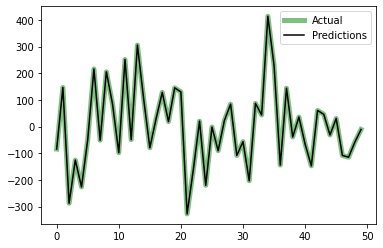

In [0]:
estimator = models[model_type](**parameters)
print(f'Estimator: {type(estimator)}')
estimator.fit(X_train, y_train)
preds = estimator.predict(X_test)
score = mean_squared_error(preds, y_test)
print(f'Score: {score}')

plt.plot(y_test[-50:], linewidth=5, alpha=0.5, c='green')
plt.plot(preds[-50:], c='black')
plt.legend(['Actual', 'Predictions'])
plt.show()

### Giving bigger weight to some algorithms

In [0]:
space_linear_prob = hp.pchoice('regressor_type', 
                                            # ridge configuration
                                            [(0.2, {'type': 'ridge', 
                                             'ridge_alpha': hp.uniform('ridge_alpha', 0,1), 
                                             }),
          
                                            # lasso configuration
                                             (0.2, {'type': 'lasso', 
                                             'lasso_alpha': hp.loguniform('lasso_alpha', np.log(0.0001),np.log(0.9))}), 
                                      
                                            # elastic configuration
                                             (0.6, {'type': 'elastic', 
                                             'elastic_alpha': hp.uniform('elastic_alpha', 0,1),
                                             'l1_ratio': hp.uniform('l1_ratio', 0,1) 
                                             })
                                            
])

trials = Trials()
best = fmin(objective, space_linear_prob, algo=tpe.suggest, max_evals=300, trials=trials)

params = space_eval(space_linear, trials.argmin)
params

100%|██████████| 300/300 [00:04<00:00, 60.01it/s, best loss: 0.0008]


{'lasso_alpha': 0.00011120111937253023, 'type': 'lasso'}